In [37]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import sys
sys.path.append('../src-py/')
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [6]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [7]:
%autoreload
import prompted_conclusion_utils as conc_utils
from utils import *
from ca_utils import *

cuda
2022-06-23 13:42:39,223 loading file ../../data-ceph/arguana/arg-generation/claim-target-tagger/model/final-model.pt


In [8]:
from datasets import load_dataset, load_metric, Dataset

from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import BartTokenizer, BartForConditionalGeneration

import torch

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
ceph_dir = '/home/sile2804/data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation'
local_home_dir = '../data'

In [11]:
tokenizer = AutoTokenizer.from_pretrained("../data/output/conc-gen-model/")
model = AutoModelForSeq2SeqLM.from_pretrained("../data/output/conc-gen-model/").to(device)

In [8]:
def generate_ds_multi_attacks(ds, model, tokenizer, premises_clm, conclusion_clm, gen_kwargs, 
                              skip_special_tokens=True, batch_size=16, nb_counters=5):
    multi_attacks = []
    for i in range(nb_counters):
        proc_ds = ds.map(lambda x :preprocess_function(x, tokenizer, premises_clm, 'counter', conclusion_clm=conclusion_clm, conclusion_idx=i), batched=True)
        proc_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
        dataloader = torch.utils.data.DataLoader(proc_ds, batch_size=batch_size)
        attacks = generate_counters(model, tokenizer, dataloader, gen_kwargs, skip_special_tokens=skip_special_tokens)
        
        #get attacked conclusions
        attacked_conclusions = ['' if i > len(x[conclusion_clm])-1 else x[conclusion_clm][i] for x in ds]
        
        multi_attacks.append(zip(attacked_conclusions, attacks))
        
    multi_attacks = list(zip(*multi_attacks)) #convert into a list of tuples, each tuple contains nb_counters
    return multi_attacks

bertscore_metric = load_metric('bertscore')
bleu_score = load_metric('bleu')


def generate_multiple_conclusions(df, post_concepts_clm="post_concepts", output_clm='post_conclusions', num_conclusions=6):
    gen_kwargs = {
        "do_sample": True, 
        "max_length":50,
        "top_p":0.95, 
        "num_beams":1
    }
    
    posts_conclusions = []
    for i in range(num_conclusions):
        control_codes = [x[i] if len(x) > i else '' for x in df[post_concepts_clm].tolist()]
        conclusions   = conc_utils.generate_prompted_conclusions(model, tokenizer, df['post'].tolist(), control_codes, gen_kwargs, batch_size=8)
        posts_conclusions.append(zip(control_codes, conclusions))

    df[output_clm] = list(map(list, zip(*posts_conclusions))) # transpose
    
    return df

def counters_coherence(post_conclusions, post_counters):
    post_counters = [nltk.sent_tokenize(x) for x in post_counters]
    conclusion_counter_sent_pairs = [(x[1], s) for x in zip(post_counters, post_conclusions) for s in x[0]]
    #print(conclusion_counter_sent_pairs)
    conclusions, counter_sents = zip(*conclusion_counter_sent_pairs)
    _, stance_labels, stance_scores = get_stance_scores(conclusions, counter_sents)
    stance_scores = [x[0] * -1 if x[1] == 0 else x[0] for x in zip(stance_scores, stance_labels)]

    #collect counter_scores
    counter_scores = []
    idx = 0
    #print(len(stance_scores))
    for i, post_counter in enumerate(post_counters):
        #print(len(post_counter))
        counter_scores.append(stance_scores[idx: idx + len(post_counter)])
        idx+=len(post_counter)
    
    #print(counter_scores)
    return [np.mean(s) for s in counter_scores]
        
def get_best_counter(post_item):
    if len(post_item) == 0:
        print('found empty')
        return ''
    if len(post_item) == 1:
        print('found one item')
        return post_item[0][2]
    
    _, post_conclusions, post_counters = zip(*post_item)
    counter_scores = counters_coherence(post_conclusions, post_counters)
    #print(sorted(list(zip(counter_scores, post_counters)), key=lambda x: -x[0]))
    #print('===================')
    return post_counters[np.argmax(counter_scores)]

--------

### Generate multiple-counters (pipeline way):

- First: generate multiple conclusions:
    - Mine concepts from the argument
    - Generate conclusions
- Second: Generate a counter for each pair of conclusion-argument

In [10]:
test_df = pd.read_pickle('../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/sample_test_conclusion_all_preprocessed.pkl')
#test_df = pd.read_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/test_conclusion_all_preprocessed.pkl')

In [29]:
test_df['post_concepts2'] = conc_utils.get_wiki_concepts(test_df['post'].tolist(), min_len=0, max_concepts=10)

TermWikifierClient: 100%|██████████| 8/8 [00:00<00:00,  8.04it/s]


In [14]:
test_df = generate_multiple_conclusions(test_df, post_concepts_clm="post_concepts2",
                                        output_clm='post_conclusions2', num_conclusions=10)

In [32]:
test_df[['title', 'post', 'post_concepts2', 'post_conclusions2']].head(n=5)

title  \
500025                                                                                                    I Don't Believe in the Big Bang   
534021                                                                                There is no reason for Britain to remain in the EU.   
415645   The Trump Administration Would Be Significantly More Harmful to US Domestic and International Policy W/out Moderates Like Mattis   
507298                             Poisoning the well against fascists is a dishonest and therefore ineffective way of combating fascists   
505763                                                                       Women have an easier time finding romantic partners than men   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [33]:
test_df.to_pickle('../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/sample_test_conclusion_all_preprocessed_multi_conclusions.pkl')
#test_df.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/test_conclusion_all_preprocessed_multi_conclusions.pkl')

In [9]:
test_df = pd.read_pickle('../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/sample_test_conclusion_all_preprocessed_multi_conclusions.pkl')

In [10]:
#Testing.....
test_df2 = generate_multiple_conclusions(test_df.sample(3), post_concepts_clm="post_concepts2",
                                        output_clm='post_conclusions2', num_conclusions=2)

Parameter 'function'=<function generate_prompted_conclusions.<locals>.<lambda> at 0x7faa6b722af0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


  0%|          | 0/1 [00:00<?, ?ba/s]

100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


In [11]:
test_df2[['post_conclusions2']].head()

,post_conclusions2
433002,"[(Fruit, Fruit making a kid play sports is fine), (Hell, Hell, I support the parent who wants his kid to play basketball/hockey)]"
524361,"[(U.S. state, U.S state presidents should be able to legally appoint more than 2 senators and 1 Senator per year), (Population, Population growth is better than a small state population, and having children is more effective than a larger state population.)]"
465537,"[(Public company, Public company disincentives should be abolished), (Company, Company Secretaries Should Be Banished)]"


In [31]:
test_df['num_concepts'] = test_df.post_concepts2.apply(lambda x: len(x))
test_df['num_conclusions'] = test_df.post_conclusions2.apply(lambda x: len(x))

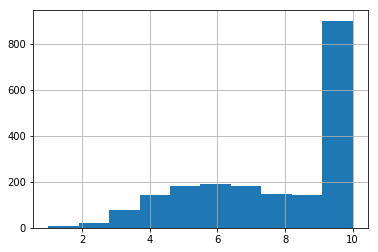

In [28]:
test_df.num_concepts.hist()

#### Now generate multiple counters:

In [9]:
data_unique_path = '/reddit_data/conclusion_and_ca_generation/sample_test_conclusion_all_preprocessed_multi_conclusions.pkl'
#data_unique_path = '/reddit_data/conclusion_and_ca_generation/test_conclusion_all_preprocessed_multi_conclusions.pkl'
data_path = '/reddit_data/conclusion_and_ca_generation/test_conclusion_all.pkl'

unique_valid_df = pd.read_pickle(ceph_dir + data_unique_path)
all_valid_df = pd.read_pickle(ceph_dir + data_path)

In [10]:
# Loading Reddit models
known_conclusion_model = BartForConditionalGeneration.from_pretrained(local_home_dir  + '/output/ca-final-models/known-conc-model/checkpoint-9500').to(device)
known_conclusion_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/ca-final-models/known-conc-model/checkpoint-9500')

In [11]:
conclusion_to_concept_dict = {item[1]: item[0] for idx, row in unique_valid_df.iterrows() for item in row['post_conclusions2']}

In [12]:
unique_valid_df['post_conclusions_no_tuples'] = unique_valid_df.post_conclusions2.apply(lambda concept_conclusion_tuples: [x[1] for x in concept_conclusion_tuples])

In [14]:
gen_kwargs = {
    "do_sample": False, 
    "max_length":100,
    "min_length":50,
    "no_repeat_ngram_size":3,
    "top_p":0.95, 
    "num_beams":4
}

valid_ds = Dataset.from_pandas(unique_valid_df)
valid_ds = valid_ds.flatten_indices()

multi_conc_attacks = generate_ds_multi_attacks(valid_ds, known_conclusion_model, known_conclusion_tokenizer, 
                                               'post', 'post_conclusions_no_tuples', gen_kwargs, nb_counters=10, batch_size=16)

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

Parameter 'function'=<function generate_ds_multi_attacks.<locals>.<lambda> at 0x7f6fca8f13a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

['Birth control should not be available to impoverished people in the US', 'Pornography should not be legally restricted to people at a certain age.', 'Inflation matters when it comes to comparing how much money a movie is actually worth. ']


  0%|          | 0/1 [00:00<?, ?ba/s]

['Child Lives are a horrible cause for suffering in the US.', 'Adolescence should be able to watch pornography without issue, and people should not have to wear an "adults only" license.', 'Avatar and endgame should be ranked at #1 in the annual box office review and should not be credited for being the number 1 movie.']


  0%|          | 0/1 [00:00<?, ?ba/s]

['Reference to the migrant crisis in the USA and Central America is unfair and hypocritical', "Society would be better off if it weren't an issue of pornography.", 'Hinge inflation is a real thing when it comes to comparing the box office gross on the first and second week, and should be taken into account when comparing the worldwide gross']


  0%|          | 0/1 [00:00<?, ?ba/s]

['Moralizing the migration crisis in the US is immoral.', 'Time restrictions should not be placed on accessing pornography.', 'Good for the dollar.']


  0%|          | 0/1 [00:00<?, ?ba/s]

['Sympathy for children apprehended by US immigration forces in immigration should be more widely extended, and should not be considered moral.', 'Number of time/seeming nudity should be legal', 'Rankings for the US "best" movies should depend on inflation']


  0%|          | 0/1 [00:00<?, ?ba/s]

['Human reproduction is immoral and should be stopped..', 'Age of majority on porn should not be specified.', ' Box Office Mojo is accurate when comparing where movie spend their money, and should be considered important']


  0%|          | 0/1 [00:00<?, ?ba/s]

['Migrant crisis in the US is making me unable to sympathize with the parents who are now suffering the majority of the consequences from having children.', "Argument against pornography is a perfectly legitimate one, but shouldn't be considered a significant issue.", ' The best movie in the series Star Wars: The Force Awakens should be ranked at rank 11 over all two other films it is being compared to.']


  0%|          | 0/1 [00:00<?, ?ba/s]

[' I have no sympathy for migrant children at the US border', 'Conversation about the best age for viewing pornography should be focused on a different issue.', ' Inflation/inflation based on worldwide box office gross should not be used to determine best movies/tours']


  0%|          | 0/1 [00:00<?, ?ba/s]

[" People in the US shouldn't have children in the first place", 'Consent Should Not be Allowed To View Pornography In Society', ' Comparisons of inflation to box office gross should be taken into account when comparing which movies have made more money']


  0%|          | 0/1 [00:00<?, ?ba/s]

[' Welfare (family subsidized) and financial aid should be given to children of poor people rather than forcing forced sterilization on them.', "Person shouldn't be required to provide proof of identification to access any site/stream/fad/gad, but rather allow young people to make choices of sex", 'The $75 million-a-year box office gross gap at the top of the average movie comparison is a good thing, and should be considered more important than how much money the movie has made. ']


In [ ]:
multi_conc_attacks = [[(conclusion_to_concept_dict[c[0]], c[0], c[1]) for c in conclusions if c[0] != ''] for conclusions in multi_conc_attacks]

In [ ]:
unique_valid_df['post_counters'] = multi_conc_attacks
unique_valid_df.to_pickle('../data/output/multi_conclusions_via_pipeline_model_nosample_4beam.pkl')

#### Generate counters with sampling:

In [48]:
gen_kwargs = {
    "do_sample": True, 
    "max_length":100,
    "min_length":50,
    "top_p":0.95,
    "no_repeat_ngram_size":3,
    "top_k": 50,
    "num_beams":4
}

valid_ds = Dataset.from_pandas(unique_valid_df)
valid_ds = valid_ds.flatten_indices()

multi_conc_attacks = generate_ds_multi_attacks(valid_ds, known_conclusion_model, known_conclusion_tokenizer, 'post', 'post_conclusions_no_tuples', gen_kwargs, nb_counters=10, batch_size=16)

Flattening the indices:   0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

['Science has proven that the Big Bang is a fact, and that is reason I am not religious..', 'Lawmakers from the UK should stop thinking of leaving the European Union', 'Military Chief Mattis has been a net positive in the Trump administration and has been praised publicly as a great ally on several international issues..']
['Education and administration is the great benefit of colonizing a country and improving its government', 'Manishplaining is not a form of racial discrimination or a form anti-feminism', 'Chief executive officer Steve Jobs will get fired from Apple soon due to his poor leadership, and I believe that Apple will become very dull and will fade from public view in the near future.']


  0%|          | 0/2 [00:00<?, ?ba/s]

['Religion is a stupid way of interpreting science', 'Sovereignty should be taken from Britain', "Transgender POTUS shouldn't have been born in the US"]
['Nationalism made India the largest country in the world, and in a lot of ways, the UK has no place in modern times', 'Existence of mansplaining has become a fact', 'Apple is a big brand that is slowly being ruined by suits and will not succeed for a while.']


  0%|          | 0/2 [00:00<?, ?ba/s]

["Factually, we know that the Big Bang wasn't the first thing that caused life.", 'European Union law is great, but it would be better if Britain quit the EU completely', "Surgery chief Rick Mattis' actions against President Trump led to a significant positive impact on US domestic and foreign policy"]
['Poverty, illiteracy, and mismanagement are not only an inevitable issue, but that has a silver lining.', 'Classic "class warfare" as we know it is doing more harm than good. ', 'Steve Jobs, the COO and current CEO for Apple is the greatest Apple executive to exist and this is a perfect example of Apple slowly, inevitably going to fail for its product lineup and is going to be an outdated and terrible company that']


  0%|          | 0/2 [00:00<?, ?ba/s]

['Idiot', 'Border control is a terrible thing to do. Britain should leave the EU.', 'Torture in Syria was a good thing. ']
['Colony colonisation made things better, which helped create a sense of unity', 'Distraction is a bad thing.', ' Apple is no longer innovative, it is just run by suits and being made for profit.']


  0%|          | 0/2 [00:00<?, ?ba/s]

['Parking violation laws are BS..', "People shouldn't feel bad about leaving the EU", 'Headquarters of the Pentagon is the best organization we have in the US']
['Looting the British colonies in the west created cohesion within the Indian subcontinent', 'Bollocks. ', ' Apple will not remain the best PC maker ever in the near future']


  0%|          | 0/2 [00:00<?, ?ba/s]

['I believe there is no such thing as the Big Bang (or the existence of the Universe)..', "Idea for why Britain shouldn't leave the EU: The borders should always be very difficult to cross, if they are there at all", 'United States Secretary of Defense General Mattis and other moderate forces in the Administration helped prevent significant harm.']
['Colonization in South India were a good thing.', 'Mansplaining is perfectly fine', ' Apple is no longer the iconic product company that everyone is excited to buy.']


  0%|          | 0/2 [00:00<?, ?ba/s]

["The Big Bang isn't a fact", "Trade blocs don't make sense, but Britain should just leave the EU..", 'Presidency of Barack Obama should not have existed without General Mattis']
['Freedom and Democracy were best for India after the British Colonization', " Mansplaining is a pathetic and illogical concept. It's just a riddle to riddle the problem with bullshit and incite anger and resentment.", ' Apple is a company that will never be innovation oriented again in the time to come.']


  0%|          | 0/2 [00:00<?, ?ba/s]

[" There is no such thing as 'the big bang'. The Big Bang is made up by people with very little scientific understanding of science.", "Sign up to this mailing list, help Britain out, and see Britain's European record if you have any concerns about Brexit.", 'Citizenship of the United States has greatly improved America']
['Conquest of India was a good thing', 'I believe that Mansplaining is a totally unimportant phenomenon. ', ' Apple is too stagnant for its own good']


  0%|          | 0/2 [00:00<?, ?ba/s]

[' the Big Bang is a myth.', " I don't think Britain should be a member of the EU, except for special circumstances", 'Senate Majority Leader Mitch McConnell (ret) should resign as Commander in Chief, because he is doing a great job preventing a lot of harm being committed to the nation by the Trump Administration']
[' Colonial rulers were right. The British colonization of India was good.', ' mansplaining is an excuse for men to be misogynist.', ' Apple will fall on hard times in the near future']


  0%|          | 0/2 [00:00<?, ?ba/s]

[' I think the Big Bang is a thing', ' Britain should quit the EU because it does nothing for the international peace.', "Secretary of State Steve Mattis should not have been appointed as the Commander of the United States's Central Command"]
[' The British Empire had a positive side effect. When the colonial rule was finally removed, it actually led to much better governance for countries like India and Africa.', ' Mansplaining is a childish and unnecessary form of discourse that should be regulated and abolished.', " I believe that Apple is on the verge of becoming a billion dollar company again and we're in a dangerous period."]


In [49]:
multi_conc_attacks = [[(conclusion_to_concept_dict[c[0]], c[0], c[1]) for c in conclusions] for conclusions in multi_conc_attacks]

unique_valid_df['post_counters'] = multi_conc_attacks
unique_valid_df.to_pickle('../data/output/multi_conclusions_via_pipeline_model_withsample_4beam.pkl')

In [51]:
print('Done')

Done


#### Choose the best counter:

In [52]:
#Using our stance classifier
unique_valid_df = pd.read_pickle('../data/output/multi_conclusions_via_pipeline_model_withsample_4beam.pkl')
unique_valid_df['best_counter'] = unique_valid_df.post_counters.apply(lambda post_item: get_best_counter(post_item))
unique_valid_df.to_pickle('../data/output/multi_conclusions_via_pipeline_model_withsample_4beam.pkl')

/usr/local/lib/python3.6/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


In [50]:
unique_valid_df = pd.read_pickle('../data/output/multi_conclusions_via_pipeline_model_nosample_4beam.pkl')
#Using our stance classifier
unique_valid_df['best_counter'] = unique_valid_df.post_counters.apply(lambda post_item: get_best_counter(post_item))
#unique_valid_df.to_pickle('../data/output/multi_conclusions_via_pipeline_model_nosample_4beam.pkl')
unique_valid_df.to_pickle('../data/output/multi_conclusions_via_pipeline_model_nosample_4beam.pkl')

/usr/local/lib/python3.6/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one 

In [55]:
unique_valid_df[['post_counters', 'best_counter']].head()

post_counters  \
500025                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   [(Science, Science has proven that the Big Bang is a fact, and that is reason I am not religious.., science has proven that the big bang is a fact, and that is reason you are not religious. science has proved that the universe was created in 6 days, and it's a fact. that's not to say that it's the only fact, but it's certainly the most important.), (Religion, Religion is a stupid way of interpreting science, religion is not a stupid way of interpreting science, it's just one of many ways of interpreting the universe. the big bang is the most obvious example of this. it's a scientific theory that explains how the universe was created.), (Fact, Factually, we know that the Big Bang wasn't the first thing that caused life., the big bang was the first thing that caused life, but it was not the only thing. it was only the first of many, many other things that have caused life. for example, the big bang is the only event that caused the universe to form. it is also the most likely cause of all life.), (Idiot, Idiot, the big bang is a scientific theory. there is no evidence to support it, but it is the only explanation for the universe being the way it is. the universe was created by an unknown 

-------

### Manually evaluate whether prompt-conclusions from both the pipeleined and joint approaches are valid conclusions:

In [38]:
import random

In [40]:
def generate_manual_eval_df(df):
    data = []
    for idx, row in df.iterrows():
        i = 0
        conclusions = [(c, 'pipeline-learning') for c in row['pipelined_conclusions']] + \
                      [(c, 'joint-learning') for c in row['joint_conclusions']] + \
                      [(c, 'joint-learning-two-decoders') for c in row['joint_two_decoders_conclusions']] + \
                      [(row['title'], 'ground-truth')]
        random.shuffle(conclusions)
        for c in conclusions :
            if i == 0:
                data.append([row['post_id'], ' '.join(row['post']), c[0], c[1]])
            else:
                data.append(['', '', c[0], c[1]])
            i+=1
    
    res_df = pd.DataFrame(data, columns=['ID', 'Argument', 'Conclusion', 'Approach name'])
    
    return res_df

In [41]:
stance_based_preds = pd.read_pickle('../data/output/ca-final-models/mt-v4/results/test_preds_df.pkl')
post_to_joint_two_seq_conclusions = pd.Series(stance_based_preds.all_pred_conclusions_no_stance.values, index=stance_based_preds.post_id).to_dict()

In [42]:
pipelined_df = pd.read_pickle('../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/sample_test_conclusion_all_preprocessed_multi_conclusions.pkl')
pipelined_df['pipelined_conclusions'] = pipelined_df.post_conclusions.apply(lambda concs: [x[1] for x in concs if x[0] != ''])

joint_df = pd.read_pickle('../data/output/multi_conclusions_via_joint_model_withsampling_4beams.pkl')
joint_df['joint_conclusions'] = joint_df['post_counters'].apply(lambda c: [x[1] for x in c if c[0] != ''])
post_to_joint_conclusions = pd.Series(joint_df.joint_conclusions.values, index=joint_df.post_id).to_dict()

In [43]:
#Test only posts where we found at least 3 concepts
pipelined_df = pipelined_df[pipelined_df.post_concepts.str.len() > 2]
sample_test = pipelined_df.sample(50)
sample_test['joint_conclusions'] = sample_test.post_id.apply(lambda x: post_to_joint_conclusions[x])
sample_test['joint_two_decoders_conclusions'] = sample_test.post_id.apply(lambda x: post_to_joint_two_seq_conclusions[x])
sample_test['joint_conclusions']     = sample_test.joint_conclusions.apply(lambda x: x[:3])
sample_test['joint_two_decoders_conclusions']     = sample_test.joint_two_decoders_conclusions.apply(lambda x: x[:3])
sample_test['pipelined_conclusions'] = sample_test.pipelined_conclusions.apply(lambda x: x[:3])

In [44]:
eval_df = generate_manual_eval_df(sample_test)

In [45]:
eval_df[['ID', 'Argument', 'Conclusion', 'Approach name']].head(n=10)

,ID,Argument,Conclusion,Approach name
0,t3_ax6ij5,"i'd like to find some counter arguments because of the obvious racist implications. it seems they are two ways of using language, with differences that seem to go way beyond of what could be explained by culture. the characteristics are as follows. perhaps the more obvious is the use of tone. type a langauges don't use tone there are no words that differ only in tone and the use of tone is completely separate from the language itself. tone is only kept when the syllable complexity or phonologcal inventory are otherwise very large, and tends to be easily lost, have more the characteristics of different kinds of stress and is almost never really important for comprehension. in type b langauges, tone works in a way that is not really different from other phonemes. tones distinguish words from each other, and it isn't much harder to find words that differ in tones than it is to find words that differ in vowels. even languages with otherwise tiny phonemic inventories may have words that differ only in tones and the language may be near impossible to understand without tone. the important here is the biological factor. languages will change when adopted by the other group as it was the case with singaporean english or afrikaans , type a children will struggle with acquiring the segmental tones, while a type b child will fail to acquire the suprasegmental tone and may speak either with a flat voice or pronounce the words with idiosyncratic tones. the most improtant difference is how the langauge is used to communicate, and leads the two groups of people intuitively self segregate, as they make effective communication nearly impossible. type a speakers transmit primarily high level information. what inferences they made. type b speakers transmit primarily low level information. what was actually observed. this will make type b seem as if they are drowning the listener in unnecessary detail, that they trying to be 'poetic' or 'deep' for no reason or that they don't actually 'understand' the meaning of what they saying, and a type a person may not listen to what is being said or fail to make the necessary inferences. type a speaker will on the other hand be seen as too vague, perhaps even intentionally so and likely even unwilling to communicate clearly and hard to understand, as the low level information expected by the type b is lacking or missing entirely. second is how the language is used to communicate. type a people use a form of communication where false statements can imply truth and true statements may imply falsehoods. conversational implicature type b speakers only use this in very specific circumstances, or not at all, and trues statements can only imply true information and false statements are always interpreted as lies. the main point again here is that the difference is biological, type a children will spontaneously learn to use language in this 'creative' way while type b children will neither do that nor they naturally learn to interpret the communication of a people correctly. this of course leads both to perceive each other as persistently lying, and may be the cause of ethnic violence throughout history. there may even be some measurable neurological differences, as it seems that type a people only process language in their left hemisphere, while type b speakers use both hemispheres, so you would need to explain how can culture rewire the brain in such a dramatic fashion.",The language faculty of West Europeans is biologically different from those of non-West Europeans.,ground-truth
1,,,"Language is a two-way street, with two types of ways of using it.",joint-learning
2,,,Human voice types are fundamentally different.,pipeline-learning
3,,,Type-A langauges are better than Type-B langauge,joint-learning-two-decoders
4,,,Biology is the main cause of the differences between type a and type b language.,joint-learning
5,,,Phoneme-based languages are superior to phoneme 

In [46]:
eval_df.to_csv('../data/manual_evaluation/eval_conclusion_sample.csv')